### 14. World Coordinates Explanation
This notebook shows to importance of using the world coordinates of images when registering them.

We will be using:
* napari (https://napari.org/stable/) for the visualization
* itk-napari-conversion (https://github.com/InsightSoftwareConsortium/itk-napari-conversion) to convert between napari layers and itk images

If you would like to use elastix directly inside napari, make sure to take a look at the elastix-napari plugin (https://github.com/SuperElastix/elastix-napari)


In [1]:
import itk
import napari
from napari.utils import nbscreenshot
import numpy as np

from itk_napari_conversion import image_from_image_layer, image_layer_from_image

We will do two registrations. One with the images containing the correct metadata regarding the physical dimensions and one that the image are first cast to numpy arrays in order to get the default physical properties (e.g spacing=[1, 1, 1])

In [2]:
# Import Images with world coordinates
fixed_image = itk.imread('data/CT_3D_lung_fixed.mha', itk.F)
moving_image = itk.imread('data/CT_3D_lung_moving.mha', itk.F)

# Recast Image to numpy, then to itk to replace original world coordinates with itk default once.
fixed_image_np = np.asarray(fixed_image).astype(np.float32)
fixed_image_np = itk.image_view_from_array(fixed_image_np)
moving_image_np = np.asarray(moving_image).astype(np.float32)
moving_image_np = itk.image_view_from_array(moving_image_np)

# Registration with original itk image 
result_image, result_transform_parameters = itk.elastix_registration_method(
    fixed_image, moving_image)

# Registration with recasted numpy image with default world coordinates.
result_image_np, result_transform_parameters = itk.elastix_registration_method(
    fixed_image_np, moving_image_np)

This is the (empty) napari viewer.

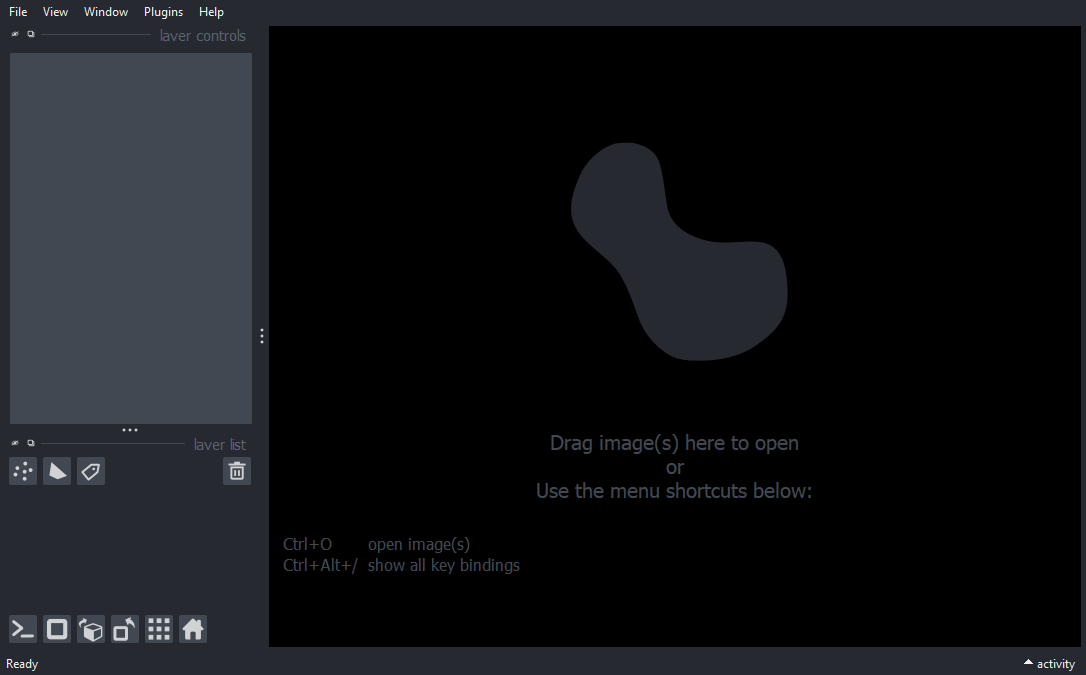

In [3]:
viewer = napari.Viewer(show=False) # switch to 'True' to get an interactive napari viewer
nbscreenshot(viewer)

Let's visualize the two result images. It is evident that they occopy different parts of the physical space.

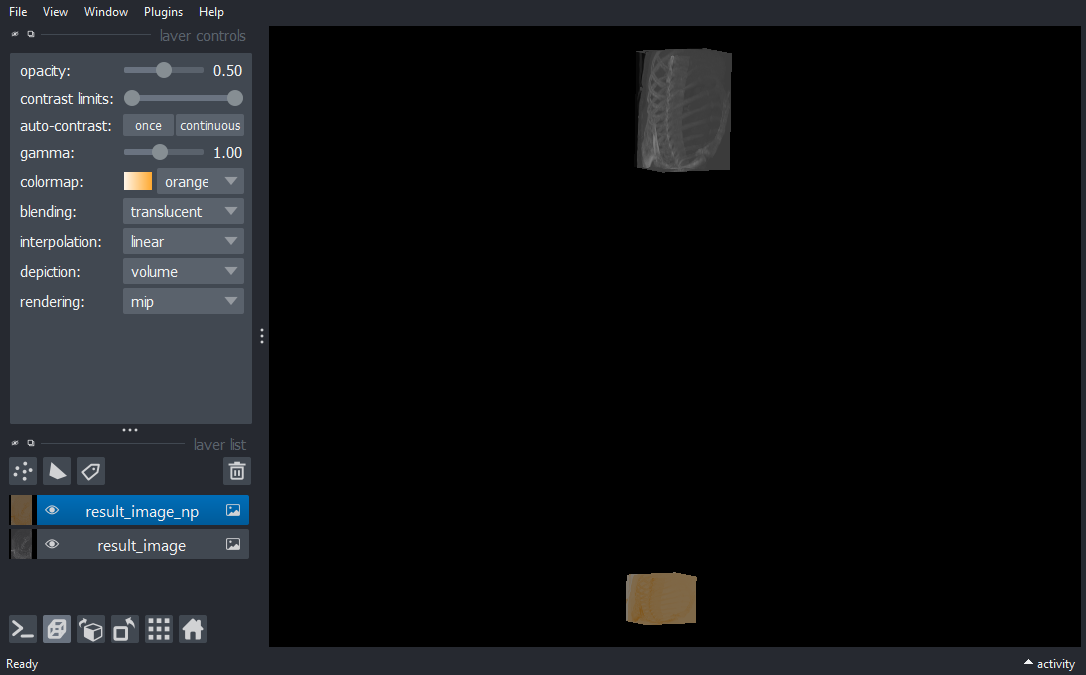

In [4]:
result_image_layer = image_layer_from_image(result_image)
result_image_layer.name = 'result_image'
result_image_layer.opacity = 0.5

result_np_image_layer = image_layer_from_image(result_image_np)
result_np_image_layer.name = 'result_image_np'
result_np_image_layer.opacity = 0.5
result_np_image_layer.colormap = 'orange'

viewer.add_layer(result_image_layer)
viewer.add_layer(result_np_image_layer)

viewer.dims.ndisplay = 3
viewer.camera.zoom = 0.35
viewer.camera.angles = (-11.2, 59.1, 168.1)
viewer.camera.center = (-653.6, 2.7, -20.0)
nbscreenshot(viewer)

Now, we will update again the metadata from the second result image which had lost its original information. When we visualize again we notice the images now occopy more-or-less the same physical space (gray and blue images overlap). However, note they are not pixel-to-pixel the same!

In summary:
* Gray image -> the result image that kept its metadata all along
* Orange image -> the result image which lost its metadata
* Blue image -> the previous (orange) image that got its metadata back

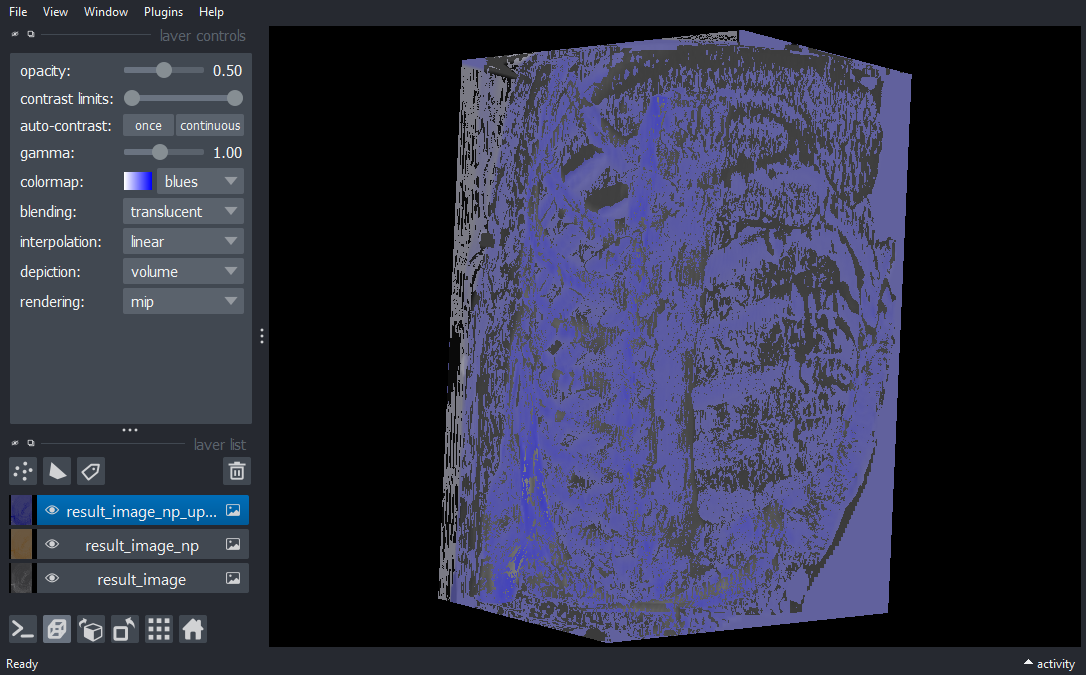

In [5]:
result_image_np_updated = itk.image_from_array(np.asarray(result_image_np))
result_image_np_updated.SetOrigin(result_image.GetOrigin())
result_image_np_updated.SetDirection(result_image.GetDirection())
result_image_np_updated.SetSpacing(result_image.GetSpacing())

result_np_image_layer_updated = image_layer_from_image(result_image_np_updated)
result_np_image_layer_updated.name = 'result_image_np_updated'
result_np_image_layer_updated.opacity = 0.5
result_np_image_layer_updated.colormap = 'blues'

viewer.add_layer(result_np_image_layer_updated)

viewer.dims.ndisplay = 3
viewer.camera.zoom = 1.7
viewer.camera.angles = (-14.8, 49.0, 163.9)
viewer.camera.center = (-1274.5, -43.8, -75.9)
nbscreenshot(viewer)